## Experimento agrupación

In [1]:
import pandas as pd
import glob
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
import multiprocessing

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from neurokit2 import ecg
import neurokit2 as nk

from models.rnn import LeadIILSTM


SAMPLING_RATE = 1000
SAMPLES_PER_CLASS = 1970
MAX_WORKERS = 8
PRE_DISPATCH = '2*n_jobs'

LEADS = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

class_folders = {
    'arritmia': 0,
    'block': 1,
    'fibrilation': 2,
    'normal': 3
}

data_folder = 'data'

In [2]:
def toFeature(signal: pd.core.frame.DataFrame, time = False):
    time_features = ["HRV_MeanNN", "HRV_SDNN", "HRV_RMSSD", "HRV_pNN50"]
    F = []
    for lead in LEADS:
        clean = nk.ecg_clean(signal[lead], sampling_rate=SAMPLING_RATE)
        _, rpeaks = nk.ecg_peaks(clean, sampling_rate=SAMPLING_RATE)
        rpeak_indices = rpeaks['ECG_R_Peaks']
        # Pasar de largo si no hay suficientes R-peaks
        if np.sum(rpeak_indices) < 2:
            F += [np.nan, np.nan, np.nan, np.nan]
            continue
        try:
            _, waves_peak = nk.ecg_delineate(clean, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")
            mean_r = np.mean([clean[i] if not np.isnan(i) else 0 for i in rpeaks['ECG_R_Peaks']]) if np.any(rpeaks['ECG_R_Peaks']) else np.nan
            mean_p = np.mean([clean[i] if not np.isnan(i) else 0 for i in waves_peak['ECG_P_Peaks']]) if 'ECG_P_Peaks' in waves_peak else np.nan
            mean_q = np.mean([clean[i] if not np.isnan(i) else 0 for i in waves_peak['ECG_Q_Peaks']]) if 'ECG_Q_Peaks' in waves_peak else np.nan
            mean_s = np.mean([clean[i] if not np.isnan(i) else 0 for i in waves_peak['ECG_S_Peaks']]) if 'ECG_S_Peaks' in waves_peak else np.nan
        except Exception:
            mean_r = mean_p = mean_q = mean_s = np.nan
        F += [mean_r, mean_p, mean_q, mean_s]
    # Features temporales con lead II:
    clean2 = nk.ecg_clean(signal["II"], sampling_rate=SAMPLING_RATE)
    _, rpeaks = nk.ecg_peaks(clean2, sampling_rate=SAMPLING_RATE)
    valid_rpeaks = [r for r in rpeaks['ECG_R_Peaks'] if not np.isnan(r)]
    if len(valid_rpeaks) >= 2: # Seguir de largo si no hay R-peaks suficientes
        if time:
            t = nk.hrv_time(rpeaks, sampling_rate=SAMPLING_RATE)
            F.extend(t[time_features].values.flatten().tolist())
    else:
        nan_count = 0
        if time: nan_count += len(time_features)
        F.extend([np.nan] * nan_count)
    return np.array(F)

In [3]:
n_jobs = -1  
verbose = 3

NORMAL_SAMPLES = 5910
NOT_NORMAL_SAMPLES = 5910
SUB_CLASSES = ['arritmia', 'block', 'fibrilation']  # will be grouped into "not_normal"
PER_SUB = NOT_NORMAL_SAMPLES // len(SUB_CLASSES)   # expected 2000

def sample_paths(folder, k):
    paths = glob.glob(os.path.join(data_folder, folder, '*.parquet.gzip'))
    if len(paths) >= k:
        return random.sample(paths, k)
    else:
        return random.choices(paths, k=k)

# sample normal
normal_paths = sample_paths('normal', NORMAL_SAMPLES)

# sample not_normal by combining samples from each subclass
not_normal_paths = []
for sub in SUB_CLASSES:
    not_normal_paths.extend(sample_paths(sub, PER_SUB))

# make file_items list of (path, label) where label: 0=normal, 1=not_normal
file_items = [(p, 0) for p in normal_paths] + [(p, 1) for p in not_normal_paths]
random.shuffle(file_items)

def _process_file(path_label):
    path, label = path_label
    try:
        df = pd.read_parquet(path, engine='fastparquet')
        # ensure required leads
        if not set(LEADS).issubset(df.columns):
            return None, label, os.path.basename(path)
        df_leads = df[LEADS].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
        feat = toFeature(df_leads, time=True)
        return feat, label, os.path.basename(path)
    except Exception:
        return None, label, os.path.basename(path)

# choose workers
cpu_count = multiprocessing.cpu_count()
if MAX_WORKERS == -1:
    workers = max(1, cpu_count - 1)
else:
    workers = min(max(1, cpu_count - 1), MAX_WORKERS)

print(f"Running feature extraction on {len(file_items)} files with {workers} workers...")

results = Parallel(
    n_jobs=workers,
    backend='loky',
    verbose=3,
    pre_dispatch=PRE_DISPATCH
)(delayed(_process_file)(item) for item in file_items)

# find first valid feature vector length
first_valid = next((r[0] for r in results if r[0] is not None), None)
if first_valid is None:
    raise RuntimeError("No features computed successfully.")

feat_len = len(first_valid)

# build features matrix, preserving order; replace bad/mismatched with NaNs
features = np.vstack([
    (r[0] if (r[0] is not None and len(r[0]) == feat_len) else np.full(feat_len, np.nan))
    for r in results
])
labels = np.array([r[1] for r in results])
ecg_ids = [r[2] for r in results]

# impute missing values (mean)
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

print("Features shape:", features_imputed.shape)
print("Label distribution:", dict(pd.Series(labels).value_counts()))

Running feature extraction on 11820 files with 7 workers...


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   19.0s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed:  2.5min
[Parallel(n_jobs=7)]: Done 498 tasks      | elapsed:  4.4min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  6.8min
[Parallel(n_jobs=7)]: Done 1138 tasks      | elapsed:  9.8min
[Parallel(n_jobs=7)]: Done 1554 tasks      | elapsed: 13.2min
[Parallel(n_jobs=7)]: Done 2034 tasks      | elapsed: 17.4min
[Parallel(n_jobs=7)]: Done 2578 tasks      | elapsed: 22.2min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 27.4min
[Parallel(n_jobs=7)]: Done 3858 tasks      | elapsed: 33.7min
[Parallel(n_jobs=7)]: Done 4594 tasks      | elapsed: 40.7min
[Parallel(n_jobs=7)]: Done 5394 tasks      | elapsed: 48.4min
[Parallel(n_jobs=7)]: Done 6258 tasks      | elapsed: 56.3min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 64.6min


Features shape: (11820, 52)
Label distribution: {0: np.int64(5910), 1: np.int64(5910)}


[Parallel(n_jobs=7)]: Done 11820 out of 11820 | elapsed: 88.7min finished


In [4]:
from collections import Counter

# Binary label counts (0=normal, 1=not_normal)
bin_counts = Counter(labels) if 'labels' in globals() else None
print("Binary label counts (0=normal, 1=not_normal):", dict(bin_counts) if bin_counts is not None else "labels not found")

# Subclass counts extracted from file paths (e.g. 'normal', 'arritmia', 'block', 'fibrilation')
if 'file_items' in globals():
    subclasses = [os.path.normpath(p).split(os.sep)[1] for p, _ in file_items]
    subclass_counts = Counter(subclasses)
    print("Counts per subclass:", dict(subclass_counts))
    # aggregated not_normal count (sum of the specified SUB_CLASSES)
    if 'SUB_CLASSES' in globals():
        not_normal_sum = sum(subclass_counts.get(s, 0) for s in SUB_CLASSES)
        print("Aggregated not_normal (sum of SUB_CLASSES):", not_normal_sum)
else:
    print("file_items not found")

Binary label counts (0=normal, 1=not_normal): {np.int64(0): 5910, np.int64(1): 5910}
Counts per subclass: {'normal': 5910, 'arritmia': 1970, 'fibrilation': 1970, 'block': 1970}
Aggregated not_normal (sum of SUB_CLASSES): 5910


KNN accuracy: 0.5960236886632826


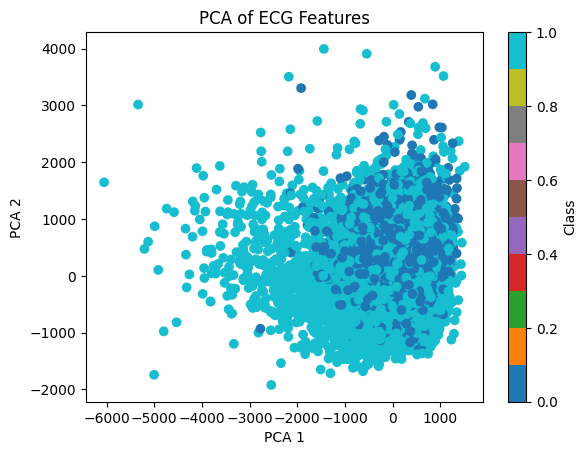

In [5]:
# PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_imputed)

# KNN

X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("KNN accuracy:", knn.score(X_test, y_test))

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of ECG Features')
plt.colorbar(label='Class')
plt.show()

In [6]:
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(features_imputed, labels, test_size=0.2, random_state=42)
clf = MLPClassifier(random_state=1, max_iter=30000, learning_rate='adaptive').fit(X_train, y_train)
clf.predict_proba(X_test[:1])
clf.predict(X_test[:5, :])
clf.score(X_test, y_test)

0.8223350253807107

In [7]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.7880710659898477

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5000, warm_start=True)

In [9]:
rf.fit(X_train, y_train)
print(rf.n_features_in_, rf.score(X_test, y_test))

52 0.9103214890016921


In [10]:
scores = []
knn = KNeighborsClassifier(n_neighbors=4)
for n in range(51):
    pca = PCA(n_components=n+2)
    features_pca = pca.fit_transform(features_imputed)
    X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

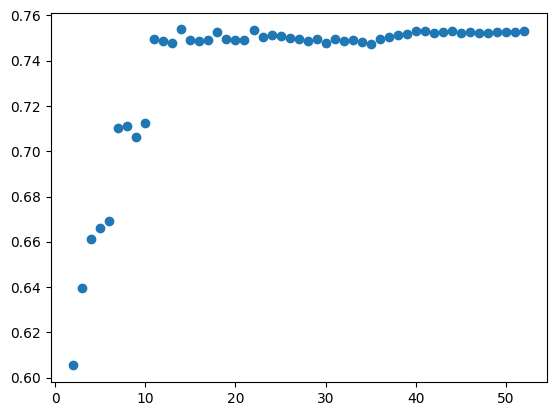

In [11]:
plt.scatter([i+2 for i in range(51)], scores)

In [12]:
# classify only the samples labeled "not_normal" (binary label==1) into the original subclasses
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# build subclass mapping from file paths (must match how file_items were created)
# prefer SUB_CLASSES if present, otherwise infer from paths
if 'SUB_CLASSES' in globals():
    subclass_names = SUB_CLASSES
else:
    subclass_names = sorted({os.path.normpath(p).split(os.sep)[1] for p, _ in file_items})

subclass_map = {name: i for i, name in enumerate(subclass_names)}

# map each file_item to subclass label (for normal files this may be 'normal')
subclass_labels_all = []
for p, _ in file_items:
    folder = os.path.normpath(p).split(os.sep)[1]
    subclass_labels_all.append(subclass_map.get(folder, -1))

subclass_labels_all = np.array(subclass_labels_all, dtype=np.int32)
labels_arr = np.array(labels)

# select not_normal rows
mask = labels_arr == 1
X_not = features_imputed[mask]
y_not = subclass_labels_all[mask]

# filter out any unknowns (-1)
valid = y_not >= 0
X_not = X_not[valid]
y_not = y_not[valid]

print("Not-normal samples:", X_not.shape[0], "class distribution:", dict(Counter(y_not)))

if X_not.shape[0] < 10:
    raise RuntimeError("Too few not-normal samples to train classifier.")

# stratified split and train a quick RandomForest baseline
X_train, X_test, y_train, y_test = train_test_split(X_not, y_not, test_size=0.2, stratify=y_not, random_state=42)

clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, target_names=subclass_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Not-normal samples: 5910 class distribution: {np.int32(0): 1970, np.int32(2): 1970, np.int32(1): 1970}
Accuracy: 0.8299492385786802
Classification report:
               precision    recall  f1-score   support

    arritmia       0.93      0.88      0.90       394
       block       0.74      0.83      0.78       394
 fibrilation       0.83      0.79      0.81       394

    accuracy                           0.83      1182
   macro avg       0.84      0.83      0.83      1182
weighted avg       0.84      0.83      0.83      1182

Confusion matrix:
 [[345  34  15]
 [ 21 326  47]
 [  5  79 310]]


In [13]:
# compute per-class feature importance (permutation) + optional SHAP
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

# feature names fallback
# 1. Recrear tu lista de 52 features
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
waves = ['P', 'Q', 'R', 'S']
hrv_features = ["HRV_MeanNN", "HRV_SDNN", "HRV_RMSSD", "HRV_pNN50"]

# Crear las 48 features de ondas (ej: 'I_P', 'I_Q', 'I_R', 'I_S', 'II_P', ...)
wave_features = [f"{lead}_{wave}" for lead in leads for wave in waves]

# Lista completa de 52 features
feature_names = wave_features + hrv_features
# Ensure X_test,y_test from previous cell (subclass training) exist
# We'll compute permutation importance on X_test for each class separately
n_repeats = 30
results_per_class = {}

for cls_idx, cls_name in enumerate(subclass_names):
    mask = (y_test == cls_idx)
    if np.sum(mask) < 5:
        print(f"Skipping class {cls_name}: too few test samples ({np.sum(mask)})")
        continue
    Xc = X_test[mask]
    yc = y_test[mask]
    # use accuracy on the class-subset as scoring (proportion of correct predictions among these samples)
    r = permutation_importance(clf, Xc, yc, n_repeats=n_repeats, scoring='accuracy', n_jobs=-1, random_state=42)
    df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': r.importances_mean,
        'importance_std': r.importances_std
    }).sort_values('importance_mean', ascending=False).reset_index(drop=True)
    results_per_class[cls_name] = df
    print(f"\nTop features for class '{cls_name}':")
    print(df.head(10).to_string(index=False))

# Global (model) feature importances (mean decrease impurity)
global_df = pd.DataFrame({
    'feature': feature_names,
    'md_imp': clf.feature_importances_
}).sort_values('md_imp', ascending=False).reset_index(drop=True)
print("\nTop global (MDI) features:")
print(global_df.head(10).to_string(index=False))

# Save results for later inspection
importance_store = {
    'per_class_permutation': results_per_class,
    'global_mdi': global_df
}


Top features for class 'arritmia':
   feature  importance_mean  importance_std
HRV_MeanNN         0.018190        0.010548
       I_Q         0.009052        0.005923
  HRV_SDNN         0.009052        0.005510
 HRV_RMSSD         0.008883        0.004481
      II_P         0.007445        0.002167
      V6_Q         0.007191        0.002628
     aVL_S         0.007107        0.003032
      II_R         0.007022        0.001816
      II_S         0.006514        0.004890
     aVL_R         0.006514        0.002980

Top features for class 'block':
feature  importance_mean  importance_std
   V1_P         0.019966        0.006739
   V2_S         0.009052        0.003689
   V2_P         0.006599        0.002232
  aVF_R         0.004992        0.003904
  aVL_P         0.004907        0.003337
    I_P         0.004907        0.002998
   V4_P         0.004653        0.005246
  III_S         0.004484        0.004331
   V3_S         0.003892        0.003259
   V3_P         0.003807        0.002

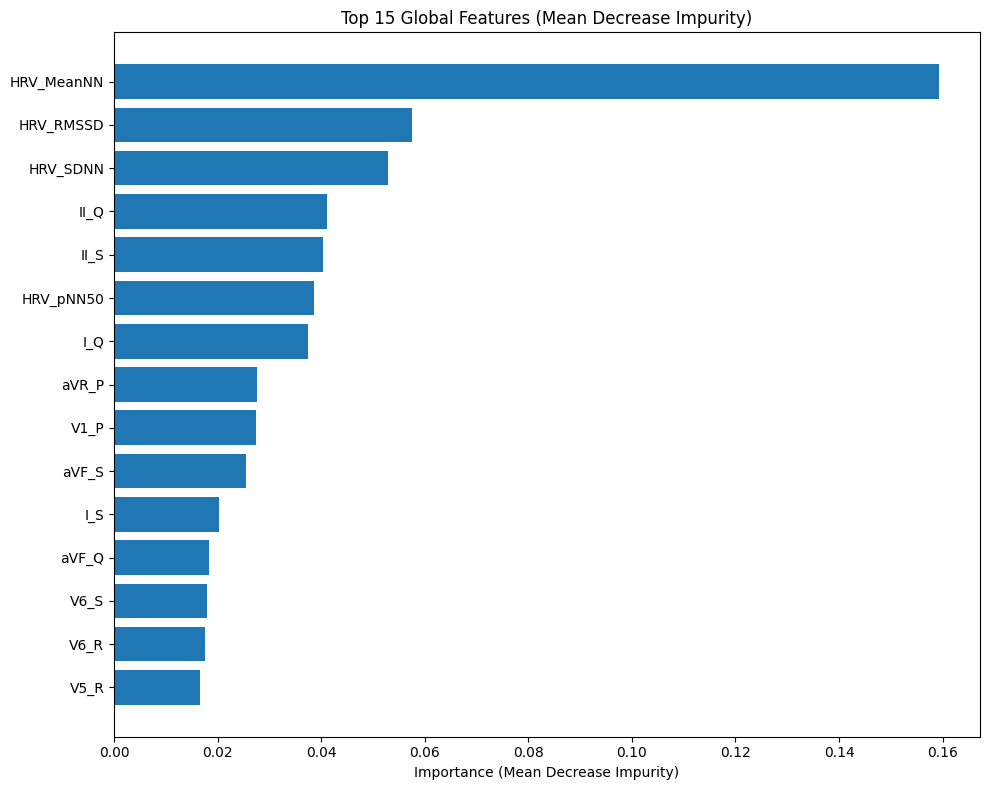

In [ ]:
# This cell uses 'global_df' from the previous cell to plot top features.
plt.figure(figsize=(10, 8))
plt.title('Top 15 Global Features (Mean Decrease Impurity)')

# Use the 'global_df' DataFrame and its 'feature' and 'md_imp' columns
df_to_plot = global_df.head(15)

plt.barh(df_to_plot['feature'], 
         df_to_plot['md_imp'],
         align='center')

plt.gca().invert_yaxis()  # Puts the most important feature at the top
plt.xlabel('Importance (Mean Decrease Impurity)')
plt.tight_layout()
plt.show()

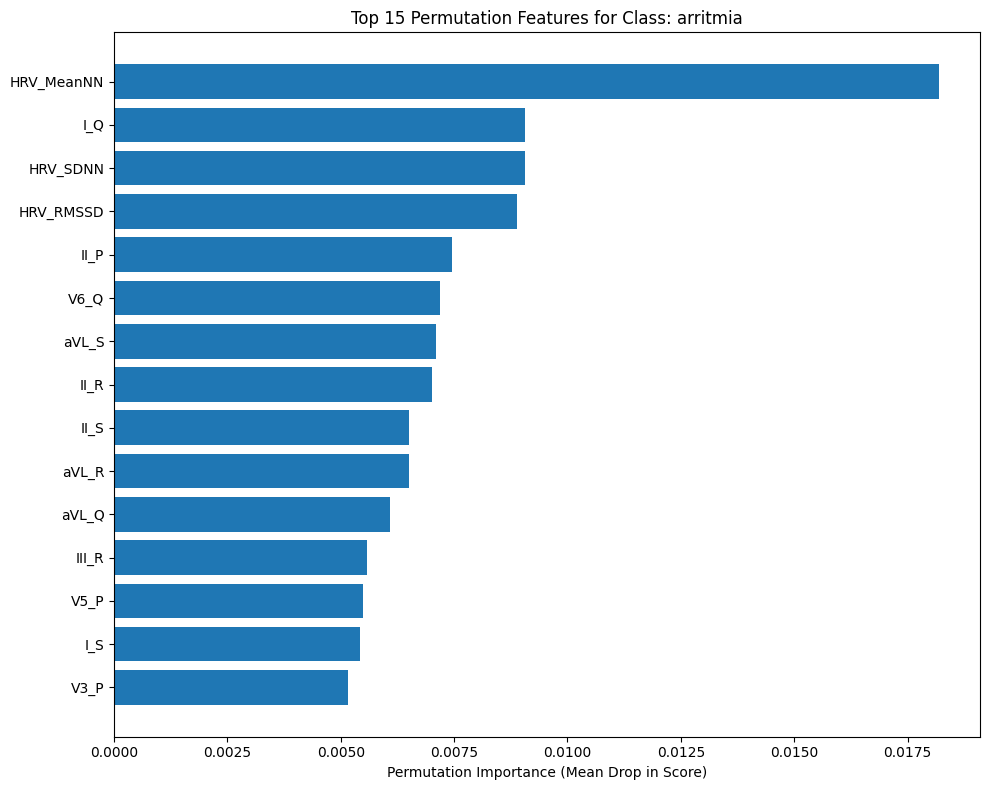

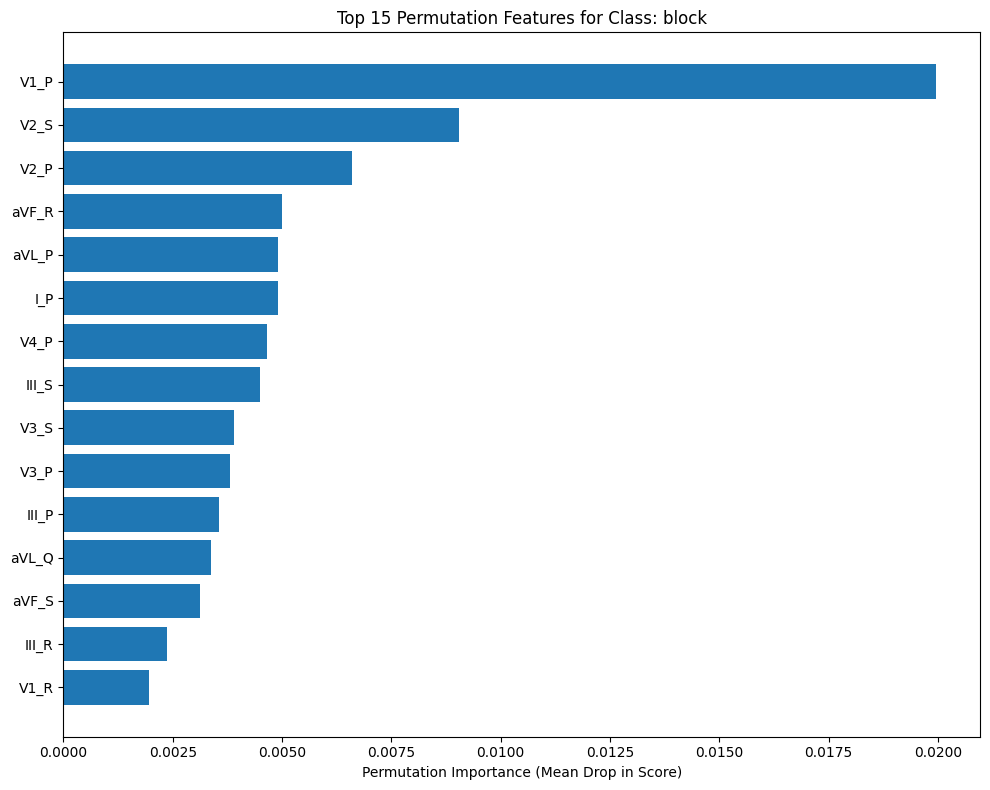

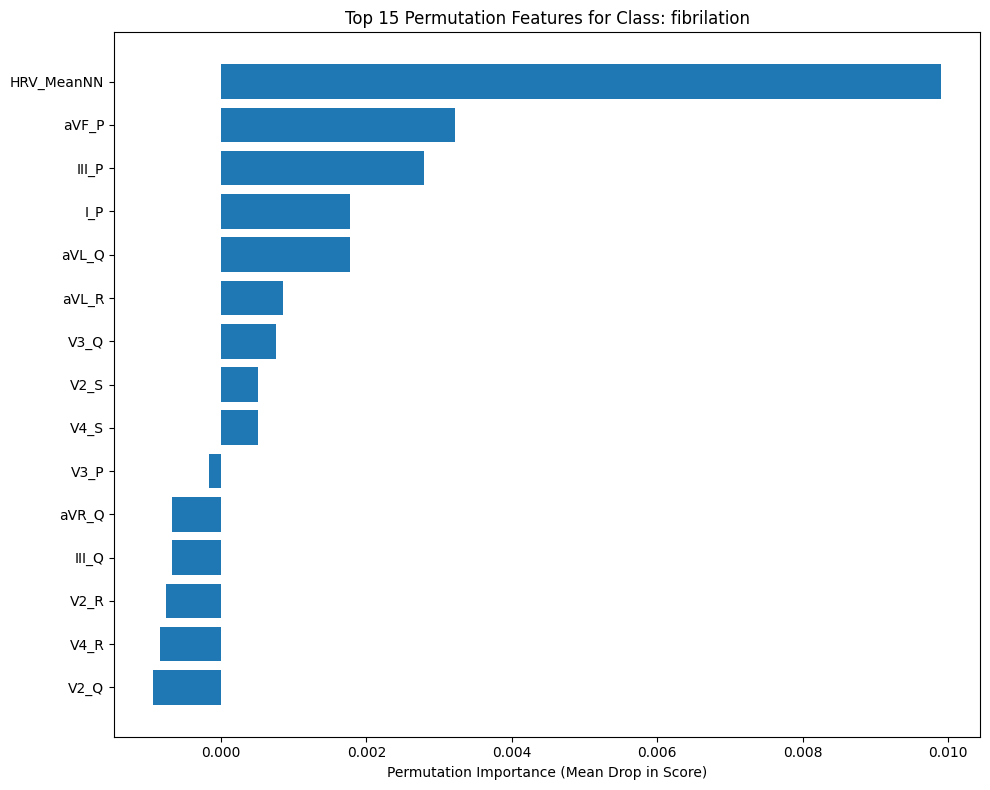

In [17]:
# This cell uses 'results_per_class' from the previous cell to plot top features for each class.
if 'results_per_class' in globals() and isinstance(results_per_class, dict):
    for class_name, df in results_per_class.items():
        # Get top 15 features for the current class
        df_to_plot = df.head(15)

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_title(f'Top 15 Permutation Features for Class: {class_name}')
        
        # Plot horizontal bars with error bars for standard deviation
        ax.barh(df_to_plot['feature'], 
                df_to_plot['importance_mean'],
                align='center',
                capsize=3)

        ax.invert_yaxis()  # Puts the most important feature at the top
        ax.set_xlabel('Permutation Importance (Mean Drop in Score)')
        fig.tight_layout()
        plt.show()
else:
    print("Variable 'results_per_class' not found. Please run the previous cell to compute per-class importances.")